# Import Data

In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
!pip list

Package                           Version
--------------------------------- ------------
aiobotocore                       2.7.0
aiohttp                           3.9.3
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.12
alembic                           1.15.2
altair                            5.0.1
anaconda-anon-usage               0.4.3
anaconda-catalogs                 0.2.0
anaconda-client                   1.12.3
anaconda-cloud-auth               0.1.4
anaconda-navigator                2.5.2
anaconda-project                  0.11.1
anyascii                          0.3.2
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.1
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astor                             0.8.1
astroid                           2.14.2
astropy                 

In [ ]:
import numpy as np
import polars as pl
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

In [ ]:
root = '/kaggle/input/child-mind-institute-detect-sleep-states/'
data= pl.read_parquet(root + 'train_series.parquet')
events = pl.read_csv(root + 'train_events.csv')
test = pl.read_parquet(root + 'test_series.parquet')

df=data.clone()
events = events.with_columns([pl.col("step").cast(pl.UInt32).alias("step")])
df1=events.clone()

In [ ]:
print(df.head())
print(events.head())
print(test.head())

shape: (5, 5)
┌──────────────┬──────┬──────────────────────────┬────────┬────────┐
│ series_id    ┆ step ┆ timestamp                ┆ anglez ┆ enmo   │
│ ---          ┆ ---  ┆ ---                      ┆ ---    ┆ ---    │
│ str          ┆ u32  ┆ str                      ┆ f32    ┆ f32    │
╞══════════════╪══════╪══════════════════════════╪════════╪════════╡
│ 038441c925bb ┆ 0    ┆ 2018-08-14T15:30:00-0400 ┆ 2.6367 ┆ 0.0217 │
│ 038441c925bb ┆ 1    ┆ 2018-08-14T15:30:05-0400 ┆ 2.6368 ┆ 0.0215 │
│ 038441c925bb ┆ 2    ┆ 2018-08-14T15:30:10-0400 ┆ 2.637  ┆ 0.0216 │
│ 038441c925bb ┆ 3    ┆ 2018-08-14T15:30:15-0400 ┆ 2.6368 ┆ 0.0213 │
│ 038441c925bb ┆ 4    ┆ 2018-08-14T15:30:20-0400 ┆ 2.6368 ┆ 0.0215 │
└──────────────┴──────┴──────────────────────────┴────────┴────────┘
shape: (5, 5)
┌──────────────┬───────┬────────┬───────┬──────────────────────────┐
│ series_id    ┆ night ┆ event  ┆ step  ┆ timestamp                │
│ ---          ┆ ---   ┆ ---    ┆ ---   ┆ ---                      │
│ str 

## Data Understanding

In [ ]:
print(data)

shape: (127_946_340, 5)
┌──────────────┬────────┬──────────────────────────┬────────────┬────────┐
│ series_id    ┆ step   ┆ timestamp                ┆ anglez     ┆ enmo   │
│ ---          ┆ ---    ┆ ---                      ┆ ---        ┆ ---    │
│ str          ┆ u32    ┆ str                      ┆ f32        ┆ f32    │
╞══════════════╪════════╪══════════════════════════╪════════════╪════════╡
│ 038441c925bb ┆ 0      ┆ 2018-08-14T15:30:00-0400 ┆ 2.6367     ┆ 0.0217 │
│ 038441c925bb ┆ 1      ┆ 2018-08-14T15:30:05-0400 ┆ 2.6368     ┆ 0.0215 │
│ 038441c925bb ┆ 2      ┆ 2018-08-14T15:30:10-0400 ┆ 2.637      ┆ 0.0216 │
│ 038441c925bb ┆ 3      ┆ 2018-08-14T15:30:15-0400 ┆ 2.6368     ┆ 0.0213 │
│ 038441c925bb ┆ 4      ┆ 2018-08-14T15:30:20-0400 ┆ 2.6368     ┆ 0.0215 │
│ …            ┆ …      ┆ …                        ┆ …          ┆ …      │
│ fe90110788d2 ┆ 592375 ┆ 2017-09-08T00:14:35-0400 ┆ -27.2775   ┆ 0.0204 │
│ fe90110788d2 ┆ 592376 ┆ 2017-09-08T00:14:40-0400 ┆ -27.032499 ┆ 0.0233 │
│

**Train Series Data**

This dataset contains accelerometer readings collected every 5 seconds. The columns are:


- series_id → Unique identifier for each device (or individual data recording session).
- step → Represents the time step, where each step increases every 5 seconds.

- timestamp → The actual date and time when the data was recorded.

- anglez → Indicates the orientation of the hand/arm (derived from accelerometer axes, used to understand posture).

- enmo (Euclidean Norm Minus One )→ a metric used to measure physical activity. Lower ENMO values indicate inactivity and help detect sleep periods.

In [ ]:
print(events)

shape: (14_508, 5)
┌──────────────┬───────┬────────┬────────┬──────────────────────────┐
│ series_id    ┆ night ┆ event  ┆ step   ┆ timestamp                │
│ ---          ┆ ---   ┆ ---    ┆ ---    ┆ ---                      │
│ str          ┆ i64   ┆ str    ┆ u32    ┆ str                      │
╞══════════════╪═══════╪════════╪════════╪══════════════════════════╡
│ 038441c925bb ┆ 1     ┆ onset  ┆ 4992   ┆ 2018-08-14T22:26:00-0400 │
│ 038441c925bb ┆ 1     ┆ wakeup ┆ 10932  ┆ 2018-08-15T06:41:00-0400 │
│ 038441c925bb ┆ 2     ┆ onset  ┆ 20244  ┆ 2018-08-15T19:37:00-0400 │
│ 038441c925bb ┆ 2     ┆ wakeup ┆ 27492  ┆ 2018-08-16T05:41:00-0400 │
│ 038441c925bb ┆ 3     ┆ onset  ┆ 39996  ┆ 2018-08-16T23:03:00-0400 │
│ …            ┆ …     ┆ …      ┆ …      ┆ …                        │
│ fe90110788d2 ┆ 33    ┆ wakeup ┆ 560604 ┆ 2017-09-06T04:07:00-0400 │
│ fe90110788d2 ┆ 34    ┆ onset  ┆ 574620 ┆ 2017-09-06T23:35:00-0400 │
│ fe90110788d2 ┆ 34    ┆ wakeup ┆ 581604 ┆ 2017-09-07T09:17:00-0400 │
│

**Train Events Data**<br>
This dataset represents sleep-related events (onset and wakeup) for each individual series.

series_id → Identifier for the individual accelerometer device

night → Indicates the night number (useful for separating multiple days of recordings).

event → Type of sleep event, either onset (sleep start) or wakeup (sleep end).

step → The time step (aligned with train_series) at which the event occurred. Each step represents 5 seconds.

timestamp → The actual date and time when the event was recorded.

**Some More information about the data**

**1. A single sleep period must be at least 30 minutes in length**
A sleep episode will only be considered valid if it lasts at least 30 minutes continuously.

Short naps or dozing off for less than 30 minutes are not recorded as sleep events.

**2. A single sleep period can be interrupted by bouts of activity that do not exceed 30 consecutive minutes** <br>
If a person wakes up or moves around briefly during sleep but for less than 30 minutes, it's still considered one continuous sleep.

Example: If someone sleeps from 10 PM to 6 AM but moves from 2:00 to 2:20 AM, it's still treated as one sleep session.

**3. No sleep windows can be detected unless the watch is deemed to be worn for the duration**<br>
If the accelerometer is not worn during the night, sleep cannot be recorded, even if the person was actually sleeping.

This is determined based on very little variation in movement, which suggests the device was removed, not that the person was inactive.

**4. The longest sleep window during the night is the only one which is recorded**<br>
If a person takes multiple naps or sleep sessions, only the longest one is considered for the night.

This is to simplify and focus on the main sleep period, which usually occurs at night.

**5. If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night**<br>
If the data does not show a valid sleep pattern, then no events (neither sleep start nor wake-up) are logged for that night.

This can happen due to poor data quality, device not being worn, or no valid sleep detected.

**6. Sleep events do not need to straddle the day-line**<br>
A sleep session doesn't have to cross midnight to be considered valid.

Example: You can have one from 01:00–06:00 AM, and another from 7:00 PM–11:30 PM on the same calendar day, and they can still be considered sleep for two different nights.

**7. There are roughly as many nights recorded for a series as there are 24-hour periods in that series**<br>
If the device was recording for 10 days, expect about 10 nights of sleep data — assuming valid sleep is detected each night.



## Train Series Analysis

In [ ]:
df = df.with_columns([
        pl.col('timestamp').str.slice(0, 19).str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S")
        .alias('timestamp_datetime')]).with_columns([
            pl.col('timestamp_datetime').dt.date().alias('date'),
            pl.col('timestamp_datetime').dt.hour().alias('hour')])


df=df.drop(["timestamp","timestamp_datetime"])
df

series_id,step,anglez,enmo,date,hour
str,u32,f32,f32,date,i8
"""038441c925bb""",0,2.6367,0.0217,2018-08-14,15
"""038441c925bb""",1,2.6368,0.0215,2018-08-14,15
"""038441c925bb""",2,2.637,0.0216,2018-08-14,15
"""038441c925bb""",3,2.6368,0.0213,2018-08-14,15
"""038441c925bb""",4,2.6368,0.0215,2018-08-14,15
…,…,…,…,…,…
"""fe90110788d2""",592375,-27.2775,0.0204,2017-09-08,0
"""fe90110788d2""",592376,-27.032499,0.0233,2017-09-08,0
"""fe90110788d2""",592377,-26.8412,0.0202,2017-09-08,0


In [ ]:
df['series_id'].n_unique()

277

There are total 277 individuals are there

In [ ]:
df['date'].describe()

statistic,value
str,str
"""count""","""127946340"""
"""null_count""","""0"""
"""mean""","""2018-07-16 01:30:41.593000"""
"""min""","""2017-08-04"""
"""25%""","""2018-02-12"""
"""50%""","""2018-07-22"""
"""75%""","""2018-12-24"""
"""max""","""2019-07-09"""


- The statistical distribution of date is indicating the data was collected from **August 4, 2017**, to **July 9, 2019**, spanning approximately **2 years**.

In [ ]:
df_copy=df['date'].to_pandas().dt.year

<Axes: xlabel='date'>

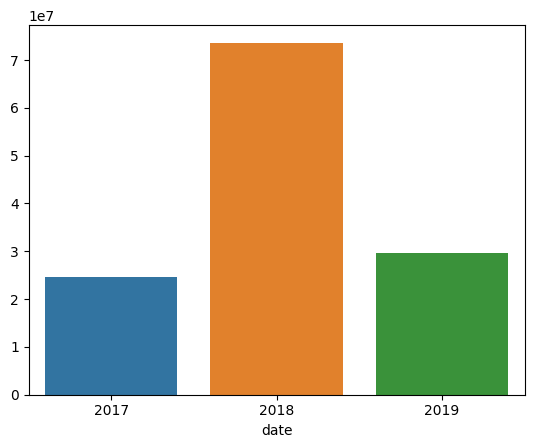

In [ ]:
df_copy.value_counts()
sns.barplot(x=df_copy.value_counts().index,y=df_copy.value_counts().values)

The plot shows that the majority of the data was collected during the year 2018. There is a noticeable drop in data volume at both the beginning and end of the time range. This pattern may indicate that data collection started gradually and tapered off toward the end. It is also possible that many individuals discontinued data generation over time, leading to reduced activity outside the peak period.

In [ ]:
df['enmo'].describe()

statistic,value
str,f64
"""count""",1.2794634e8
"""null_count""",0.0
"""mean""",0.041315
"""std""",0.101829
"""min""",0.0
"""25%""",0.0013
"""50%""",0.0172
"""75%""",0.0437
"""max""",11.4337


**Formula for enmo value is:**<br>
![image.png](attachment:d289890f-3b36-409b-94c8-f7bfebeea05f.png)

- It measures overall movement, with higher values indicating more activity.

If we abserve clearly the enmo values are ranges from 0 to 11.4337

In [ ]:
a=df.to_pandas()
a

,series_id,step,anglez,enmo,date,hour
0,038441c925bb,0,2.636700,0.0217,2018-08-14,15
1,038441c925bb,1,2.636800,0.0215,2018-08-14,15
2,038441c925bb,2,2.637000,0.0216,2018-08-14,15
3,038441c925bb,3,2.636800,0.0213,2018-08-14,15
4,038441c925bb,4,2.636800,0.0215,2018-08-14,15
...,...,...,...,...,...,...
127946335,fe90110788d2,592375,-27.277500,0.0204,2017-09-08,0
127946336,fe90110788d2,592376,-27.032499,0.0233,2017-09-08,0
127946337,fe90110788d2,592377,-26.841200,0.0202,2017-09-08,0
127946338,fe90110788d2,592378,-26.723900,0.0199,2017-09-08,0


<Axes: xlabel='hour'>

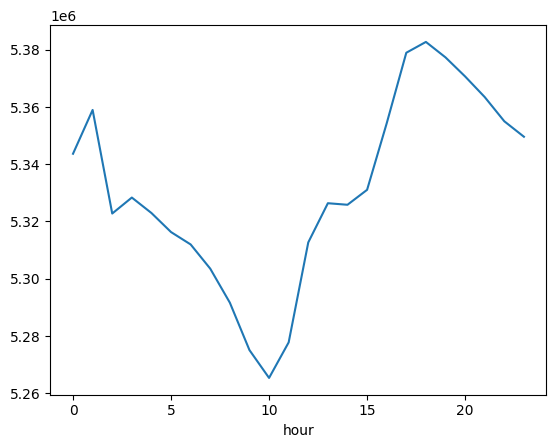

In [ ]:
b=a.groupby('hour')['enmo'].count()
sns.lineplot(x=b.index,y=b.values)

**Enmo Values Pattern by time**<br>
Observing the trend in ENMO values across the day, we notice a clear dip around hour 10, indicating a period of low activity. Following this low point, there's a significant and rapid increase in ENMO values, peaking around hour 18. This suggests a substantial rise in activity levels between these hours.

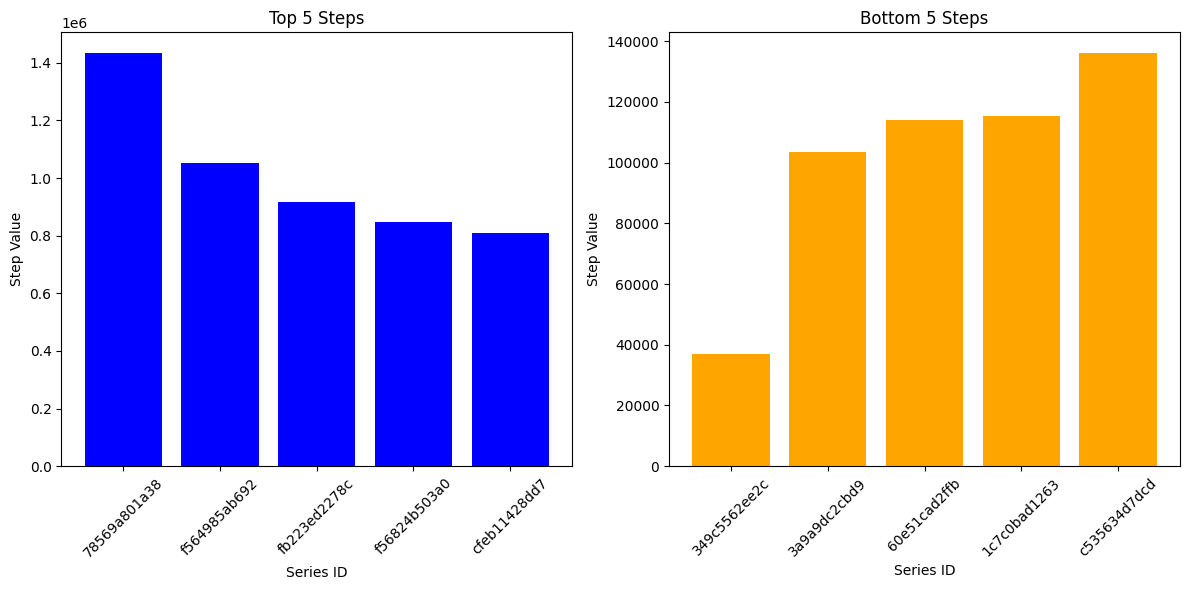

In [ ]:
top_steps = a.groupby('series_id')['step'].max().sort_values(ascending=False).head()
bottom_steps = a.groupby('series_id')['step'].max().sort_values(ascending=True).head()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(top_steps.index, top_steps.values, color='blue')
axs[0].set_title("Top 5 Steps")
axs[0].set_xlabel("Series ID")
axs[0].set_ylabel("Step Value")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(bottom_steps.index, bottom_steps.values, color='orange')
axs[1].set_title("Bottom 5 Steps")
axs[1].set_xlabel("Series ID")
axs[1].set_ylabel("Step Value")
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


**Top–Bottom People Time Pattern**<br>
**First plot**: These individuals have the highest step counts, indicating they are using the accumulators for longer durations compared to others.(here 1.4 - 1.4 million)

**Second plot**: These individuals have the lowest step counts, suggesting they use the accumulators for shorter durations compared to the rest.

hand position based ont the anglez value

![anglez positions.png](attachment:9da31a82-fdf5-4ce0-b114-92ee950adc36.png)

**Formula of the anglez value is:**

![image.png](attachment:6989d533-c961-4dee-bf9a-81208ff76fce.png)

- It measures arm orientation relative to gravity (up/down tilt).


**What are x, y, z in ENMO and AngleZ?**<br>
x: Acceleration in the lateral direction (side-to-side).

y: Acceleration in the forward-backward direction (along the body).

z: Acceleration in the vertical direction (toward the sky or ground, depending on orientation).



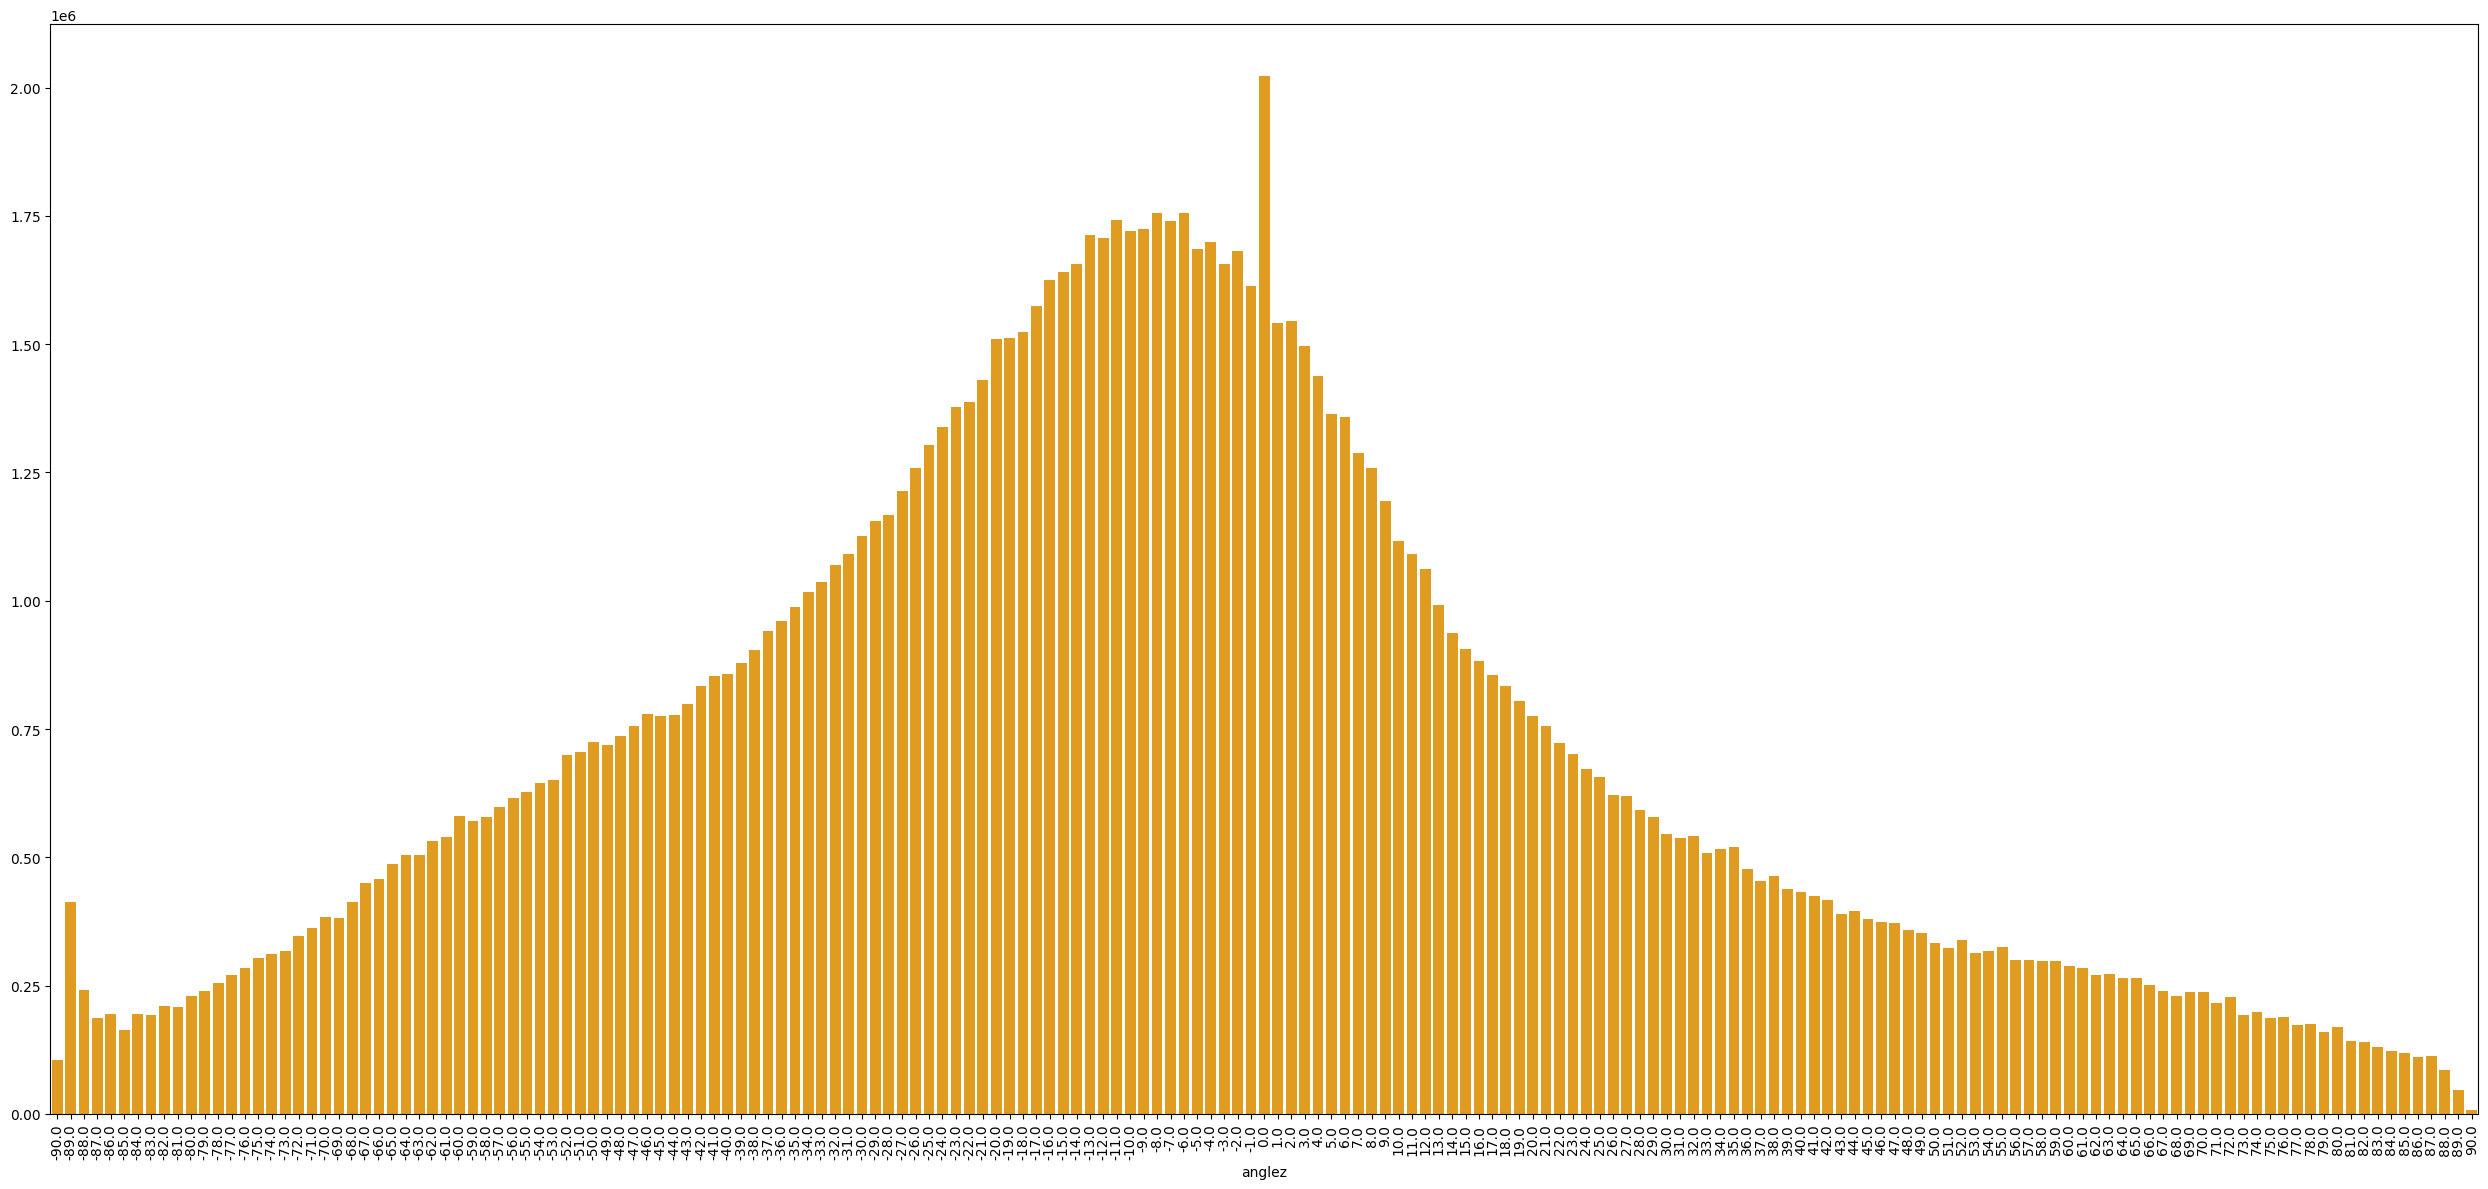

In [ ]:
b=a['anglez'].value_counts()
b.index=b.index.round()
b=pd.DataFrame({
    "anglez": b.index,
    "count": b.values
}).groupby("anglez")['count'].sum()


plt.figure(figsize=(25, 12))
sns.barplot(x=b.index, y=b.values, color='orange')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Anglez data distribution**<br>
- Based on this, the anglez count distribution is bell-shaped, indicating it follows a normal distribution with a slight right skew. One key observation is that the anglez value of 0 occurs significantly more often compared to other values, suggesting that most individuals' hand positions are at rest.

- Furthermore, between anglez values of -84 to -89, there is an increase in anglez values, which corresponds to a shift in the hand position.

In [ ]:
a=df.to_pandas()
a

,series_id,step,anglez,enmo,date,hour
0,038441c925bb,0,2.636700,0.0217,2018-08-14,15
1,038441c925bb,1,2.636800,0.0215,2018-08-14,15
2,038441c925bb,2,2.637000,0.0216,2018-08-14,15
3,038441c925bb,3,2.636800,0.0213,2018-08-14,15
4,038441c925bb,4,2.636800,0.0215,2018-08-14,15
...,...,...,...,...,...,...
127946335,fe90110788d2,592375,-27.277500,0.0204,2017-09-08,0
127946336,fe90110788d2,592376,-27.032499,0.0233,2017-09-08,0
127946337,fe90110788d2,592377,-26.841200,0.0202,2017-09-08,0
127946338,fe90110788d2,592378,-26.723900,0.0199,2017-09-08,0


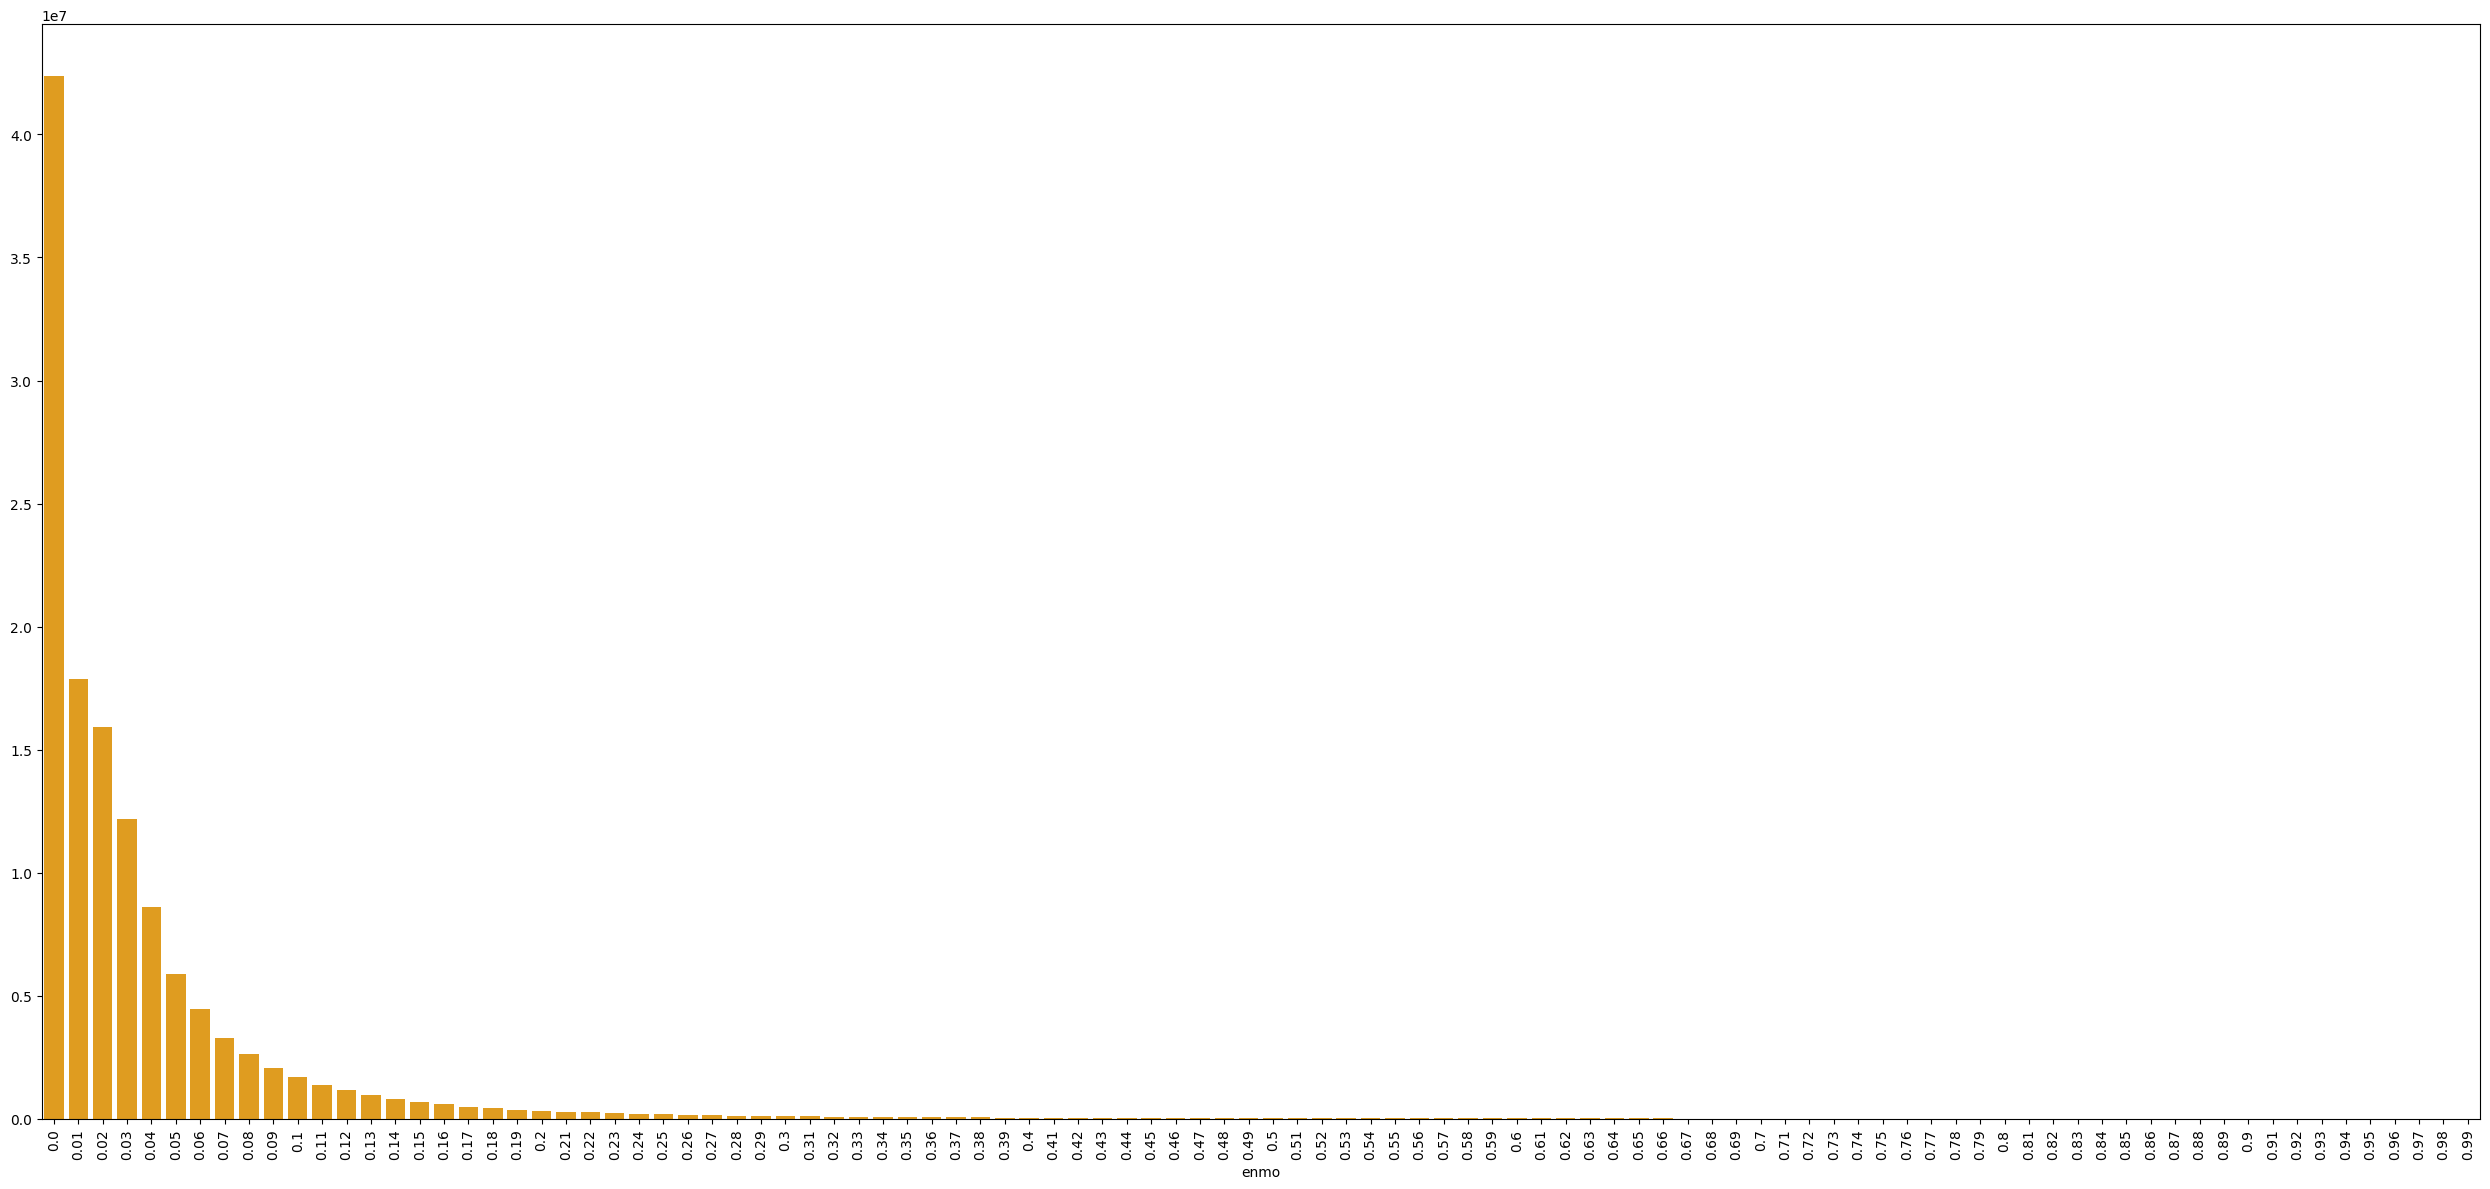

In [ ]:
b=a['enmo'].value_counts()
b.index=b.index.round(2)
b=pd.DataFrame({
    "enmo": b.index,
    "count": b.values
})

b=b[b['enmo']<1]
b=b.groupby("enmo")['count'].sum()
plt.figure(figsize=(25, 12))
sns.barplot(x=b.index, y=b.values, color='orange')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**Enmo Values distribution**

- The ENMO distribution is highly right-skewed and follows a log-normal pattern, with most values clustered near 0.00, indicating long periods of inactivity or sleep.

- The ENMO value "0.00" dominates the distribution, meaning most individuals are at rest for a significant portion of time.

- ENMO values starting from 0.70 onward appear consistently, suggesting these are not outliers, but periods of high activity seen across different individuals.

- The gradual decrease from low to high ENMO bins reflects natural human activity, with rest being most frequent, followed by light and moderate movements, and fewer intense activity bursts.

## Events Data Analysis

In [ ]:
print(df1)
print("No of individuals :",df1['series_id'].n_unique())

shape: (14_508, 5)
┌──────────────┬───────┬────────┬────────┬──────────────────────────┐
│ series_id    ┆ night ┆ event  ┆ step   ┆ timestamp                │
│ ---          ┆ ---   ┆ ---    ┆ ---    ┆ ---                      │
│ str          ┆ i64   ┆ str    ┆ u32    ┆ str                      │
╞══════════════╪═══════╪════════╪════════╪══════════════════════════╡
│ 038441c925bb ┆ 1     ┆ onset  ┆ 4992   ┆ 2018-08-14T22:26:00-0400 │
│ 038441c925bb ┆ 1     ┆ wakeup ┆ 10932  ┆ 2018-08-15T06:41:00-0400 │
│ 038441c925bb ┆ 2     ┆ onset  ┆ 20244  ┆ 2018-08-15T19:37:00-0400 │
│ 038441c925bb ┆ 2     ┆ wakeup ┆ 27492  ┆ 2018-08-16T05:41:00-0400 │
│ 038441c925bb ┆ 3     ┆ onset  ┆ 39996  ┆ 2018-08-16T23:03:00-0400 │
│ …            ┆ …     ┆ …      ┆ …      ┆ …                        │
│ fe90110788d2 ┆ 33    ┆ wakeup ┆ 560604 ┆ 2017-09-06T04:07:00-0400 │
│ fe90110788d2 ┆ 34    ┆ onset  ┆ 574620 ┆ 2017-09-06T23:35:00-0400 │
│ fe90110788d2 ┆ 34    ┆ wakeup ┆ 581604 ┆ 2017-09-07T09:17:00-0400 │
│

- There are a total of 277 individuals, meaning this data has been collected from the raw accumulators of 277 individuals.

In [ ]:
print(df1)

shape: (14_508, 5)
┌──────────────┬───────┬────────┬────────┬──────────────────────────┐
│ series_id    ┆ night ┆ event  ┆ step   ┆ timestamp                │
│ ---          ┆ ---   ┆ ---    ┆ ---    ┆ ---                      │
│ str          ┆ i64   ┆ str    ┆ u32    ┆ str                      │
╞══════════════╪═══════╪════════╪════════╪══════════════════════════╡
│ 038441c925bb ┆ 1     ┆ onset  ┆ 4992   ┆ 2018-08-14T22:26:00-0400 │
│ 038441c925bb ┆ 1     ┆ wakeup ┆ 10932  ┆ 2018-08-15T06:41:00-0400 │
│ 038441c925bb ┆ 2     ┆ onset  ┆ 20244  ┆ 2018-08-15T19:37:00-0400 │
│ 038441c925bb ┆ 2     ┆ wakeup ┆ 27492  ┆ 2018-08-16T05:41:00-0400 │
│ 038441c925bb ┆ 3     ┆ onset  ┆ 39996  ┆ 2018-08-16T23:03:00-0400 │
│ …            ┆ …     ┆ …      ┆ …      ┆ …                        │
│ fe90110788d2 ┆ 33    ┆ wakeup ┆ 560604 ┆ 2017-09-06T04:07:00-0400 │
│ fe90110788d2 ┆ 34    ┆ onset  ┆ 574620 ┆ 2017-09-06T23:35:00-0400 │
│ fe90110788d2 ┆ 34    ┆ wakeup ┆ 581604 ┆ 2017-09-07T09:17:00-0400 │
│

In [ ]:
df1.to_pandas().duplicated().sum()
# means there is no duplicated values

0

## Events missing Values Handling

In [ ]:
df1.to_pandas().isna().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64

In [ ]:
a=df1.pivot(index=['series_id','night'],columns='event',values='step').to_pandas()
a

,series_id,night,onset,wakeup
0,038441c925bb,1,4992.0,10932.0
1,038441c925bb,2,20244.0,27492.0
2,038441c925bb,3,39996.0,44400.0
3,038441c925bb,4,57240.0,62856.0
4,038441c925bb,5,NaN,NaN
...,...,...,...,...
7249,fe90110788d2,31,522852.0,529104.0
7250,fe90110788d2,32,538956.0,547152.0
7251,fe90110788d2,33,556560.0,560604.0
7252,fe90110788d2,34,574620.0,581604.0


In [ ]:
b=a[(a['onset'].isna() & a['wakeup'].notna()) | (a['onset'].notna() & a['wakeup'].isna())]
b

,series_id,night,onset,wakeup
279,0ce74d6d2106,20,332376.0,NaN
712,154fe824ed87,30,NaN,514980.0
1939,44a41bba1ee7,10,NaN,165684.0
6776,efbfc4526d58,7,NaN,114864.0
7052,f8a8da8bdd00,17,NaN,291384.0


In [ ]:
for i,j in zip(b['series_id'],b['night']):
    print(i,j)
    df1=df1.with_columns(
        pl.when((pl.col('series_id') == i) & (pl.col('night') == j)).then(None).otherwise(pl.col('step')).alias('step'),
        pl.when((pl.col('series_id') == i) & (pl.col('night') == j)).then(None).otherwise(pl.col('timestamp')).alias('timestamp')
    )


0ce74d6d2106 20
154fe824ed87 30
44a41bba1ee7 10
efbfc4526d58 7
f8a8da8bdd00 17


In [ ]:
a=df1.pivot(index=['series_id','night'],columns='event',values='step').to_pandas()
b=a[(a['onset'].isna() & a['wakeup'].notna()) | (a['onset'].notna() & a['wakeup'].isna())]
b

,series_id,night,onset,wakeup


In [ ]:
df1.to_pandas().isna().sum()

series_id       0
night           0
event           0
step         4928
timestamp    4928
dtype: int64

In [ ]:
df1=(df1.filter(~(pl.col("timestamp").is_null() & pl.col("step").is_null())))
print(df1.head())

shape: (5, 5)
┌──────────────┬───────┬────────┬───────┬──────────────────────────┐
│ series_id    ┆ night ┆ event  ┆ step  ┆ timestamp                │
│ ---          ┆ ---   ┆ ---    ┆ ---   ┆ ---                      │
│ str          ┆ i64   ┆ str    ┆ u32   ┆ str                      │
╞══════════════╪═══════╪════════╪═══════╪══════════════════════════╡
│ 038441c925bb ┆ 1     ┆ onset  ┆ 4992  ┆ 2018-08-14T22:26:00-0400 │
│ 038441c925bb ┆ 1     ┆ wakeup ┆ 10932 ┆ 2018-08-15T06:41:00-0400 │
│ 038441c925bb ┆ 2     ┆ onset  ┆ 20244 ┆ 2018-08-15T19:37:00-0400 │
│ 038441c925bb ┆ 2     ┆ wakeup ┆ 27492 ┆ 2018-08-16T05:41:00-0400 │
│ 038441c925bb ┆ 3     ┆ onset  ┆ 39996 ┆ 2018-08-16T23:03:00-0400 │
└──────────────┴───────┴────────┴───────┴──────────────────────────┘


In [ ]:
df1.to_pandas().isna().sum()

series_id    0
night        0
event        0
step         0
timestamp    0
dtype: int64

In [ ]:
df1['event'].to_pandas().value_counts()

event
onset     4790
wakeup    4790
Name: count, dtype: int64

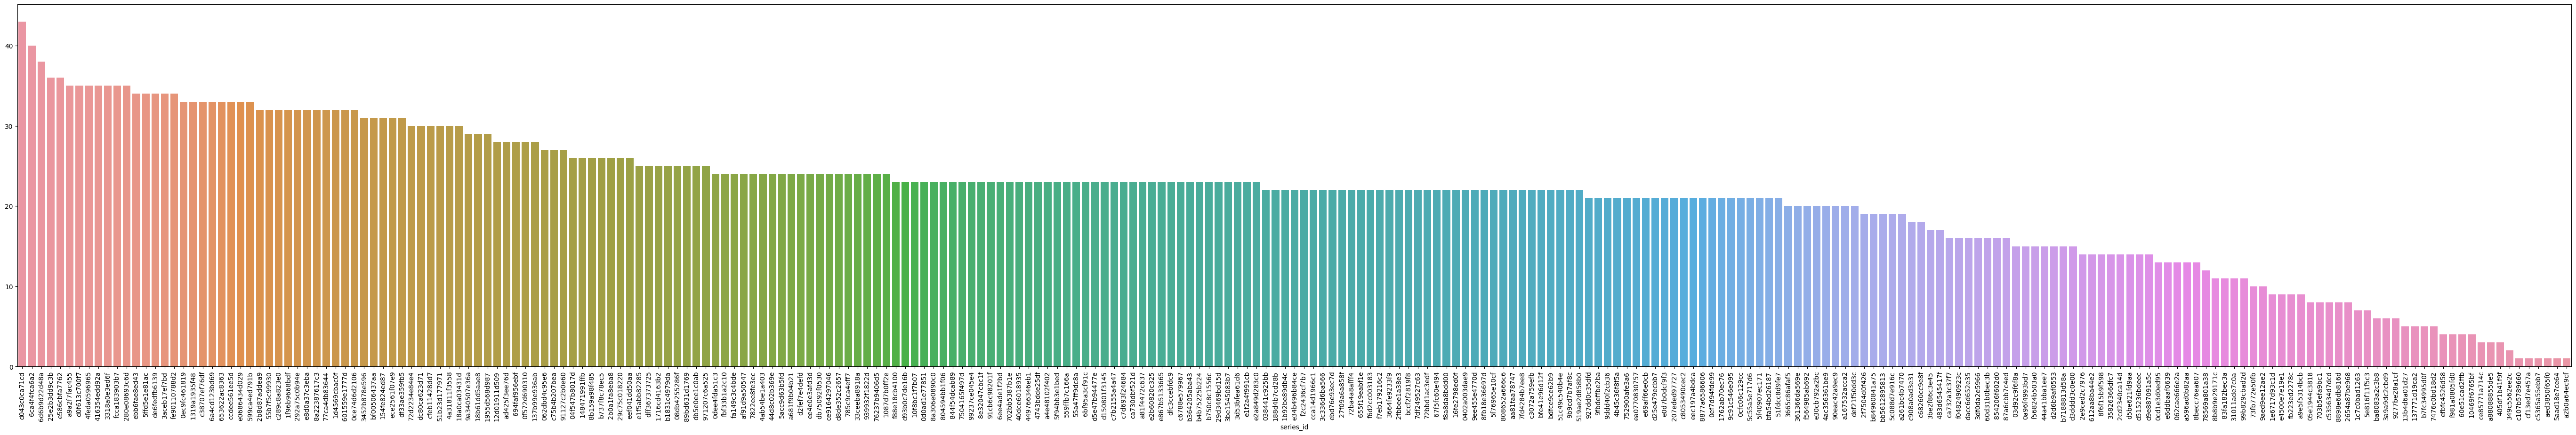

In [ ]:
a=df1.to_pandas()
a=a.groupby("series_id")['night'].max().sort_values(ascending=False)
plt.figure(figsize=(70, 10))
sns.barplot(x=a.index, y=a.values)
plt.xticks(rotation=90)
plt.show()

- The individual with enc_id **78569a801a38** has contributed the highest number of nights of data, indicating consistent and prolonged device usage or tracking — significantly more than others.

- The distribution is right-skewed, meaning only a few individuals have high night-level data, while most individuals have moderate to low night-level records, potentially due to early drop-off, incomplete tracking, or shorter study duration.

In [ ]:
df1 = df1.with_columns([
        pl.col('timestamp').str.slice(0, 19).str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S")
        .alias('timestamp_datetime')]).with_columns([
            pl.col('timestamp_datetime').dt.date().alias('date'),
            pl.col('timestamp_datetime').dt.hour().alias('hour')])
df1=df1.drop(["timestamp","timestamp_datetime"])

In [ ]:
a=df1.pivot(index=['series_id', 'night'], columns='event', values='hour').to_pandas()
a

,series_id,night,onset,wakeup
0,038441c925bb,1,22,6
1,038441c925bb,2,19,5
2,038441c925bb,3,23,5
3,038441c925bb,4,23,6
4,038441c925bb,6,22,7
...,...,...,...,...
4785,fe90110788d2,30,23,7
4786,fe90110788d2,31,23,8
4787,fe90110788d2,32,22,9
4788,fe90110788d2,33,22,4


In [ ]:
a['sleep_hours'] = np.where(
    a['wakeup'] >= a['onset'],
    a['wakeup'] - a['onset'],
    (24 - a['onset']) + a['wakeup'])

In [ ]:
a

,series_id,night,onset,wakeup,sleep_hours
0,038441c925bb,1,22,6,8
1,038441c925bb,2,19,5,10
2,038441c925bb,3,23,5,6
3,038441c925bb,4,23,6,7
4,038441c925bb,6,22,7,9
...,...,...,...,...,...
4785,fe90110788d2,30,23,7,8
4786,fe90110788d2,31,23,8,9
4787,fe90110788d2,32,22,9,11
4788,fe90110788d2,33,22,4,6


In [ ]:
a.to_csv("Sleep_patterns.csv")

Id ad425f3ee76d sleep pattern :


<Axes: xlabel='night', ylabel='sleep_hours'>

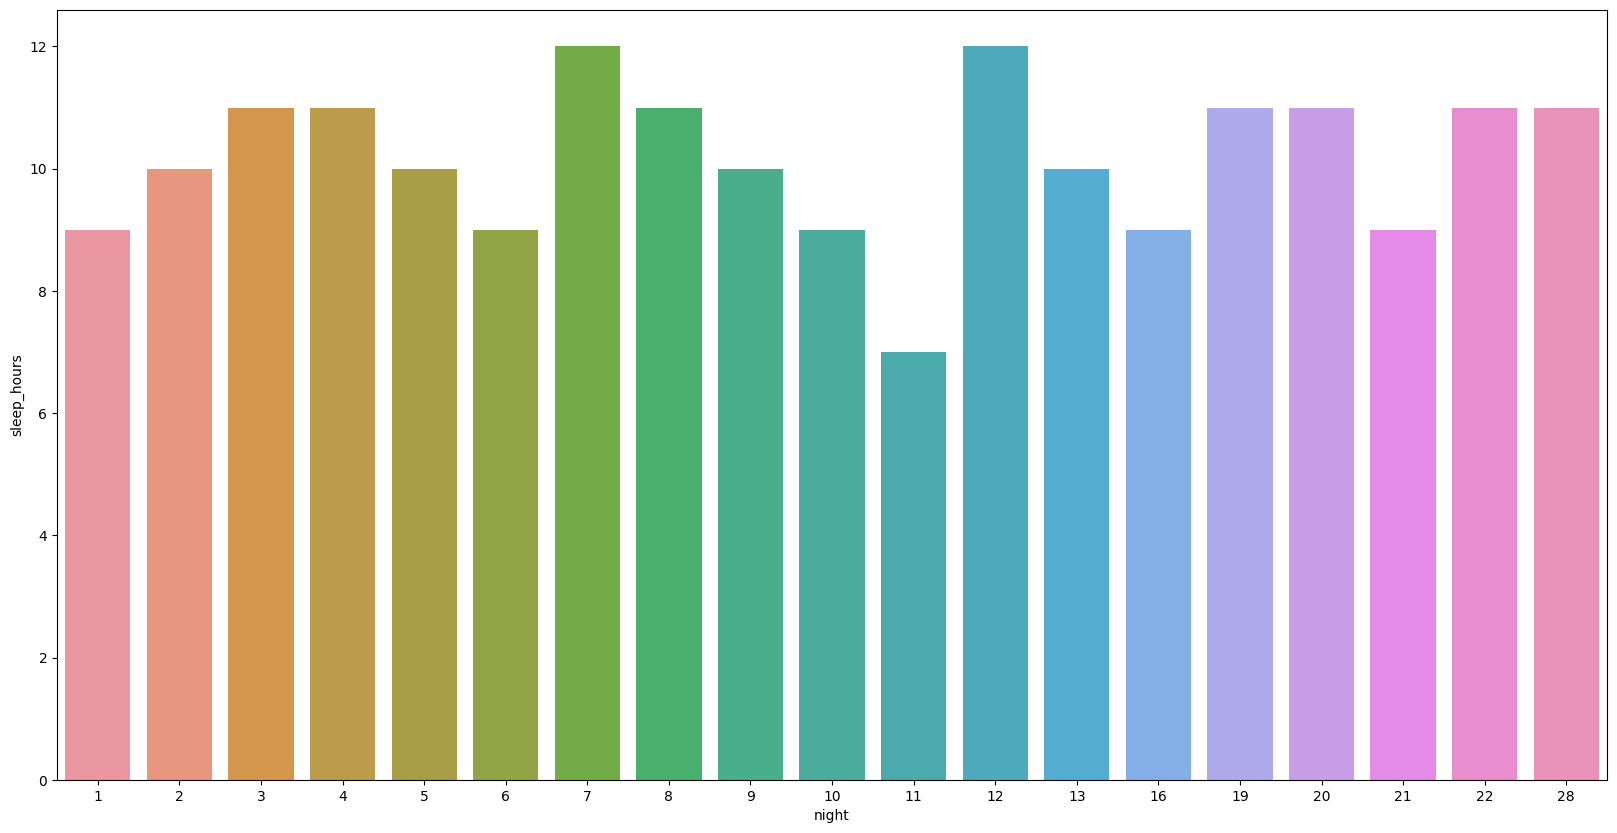

In [ ]:
s_id=np.random.choice(np.array(df1['series_id'].unique()))
b=a.loc[a['series_id']==s_id,["night",'sleep_hours']]

print(f"Id {s_id} sleep pattern :")
plt.figure(figsize=(20, 10))
sns.barplot(x=b['night'],y=b['sleep_hours'])



**Individual's Sleep Pattern**<br>
Understanding a person's sleep pattern helps us determine whether they are following a healthy routine.
- If they are not, it may increase their risk of health issues.
- Sleeping too little can be harmful, but oversleeping can also lead to problems such as increased fatigue and laziness.



In [ ]:
data_1 = df.join(df1[['series_id', 'step', 'event']], on=['series_id', 'step'], how='inner').sort(by=['series_id', 'step'])
data_1

series_id,step,anglez,enmo,date,hour,event
str,u32,f32,f32,date,i8,str
"""038441c925bb""",4992,-78.690598,0.0099,2018-08-14,22,"""onset"""
"""038441c925bb""",10932,-61.578201,0.0263,2018-08-15,6,"""wakeup"""
"""038441c925bb""",20244,-6.3874,0.0182,2018-08-15,19,"""onset"""
"""038441c925bb""",27492,-45.355099,0.0165,2018-08-16,5,"""wakeup"""
"""038441c925bb""",39996,-1.7867,0.0,2018-08-16,23,"""onset"""
…,…,…,…,…,…,…
"""fe90110788d2""",547152,-56.768902,0.0042,2017-09-05,9,"""wakeup"""
"""fe90110788d2""",556560,-16.5867,0.0,2017-09-05,22,"""onset"""
"""fe90110788d2""",560604,-43.0509,0.0,2017-09-06,4,"""wakeup"""


If we look here, there are a total of six features. However, based on general knowledge, it's not necessary to use all of them for training the model. Therefore, I will select only two input features: anglez and enmo.

In [ ]:
data_1=data_1[['anglez','enmo','event']]

In [ ]:
data_1

anglez,enmo,event
f32,f32,str
-78.690598,0.0099,"""onset"""
-61.578201,0.0263,"""wakeup"""
-6.3874,0.0182,"""onset"""
-45.355099,0.0165,"""wakeup"""
-1.7867,0.0,"""onset"""
…,…,…
-56.768902,0.0042,"""wakeup"""
-16.5867,0.0,"""onset"""
-43.0509,0.0,"""wakeup"""


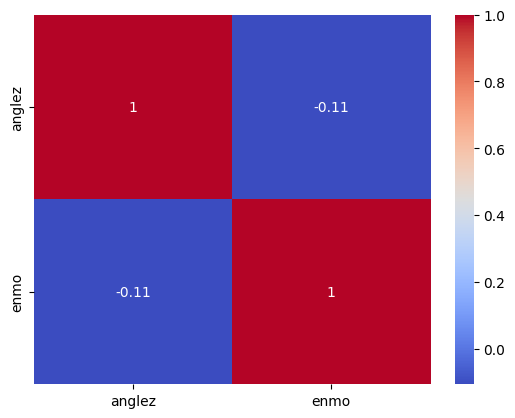

In [ ]:
corr_matrix = (data_1.to_pandas()).select_dtypes(include='number').corr()

# Now plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

**Relation Ship between Features**<br>
If we observe here there is very less negative relation ship is there between these two input features anglez and enmo

<Axes: xlabel='anglez', ylabel='enmo'>

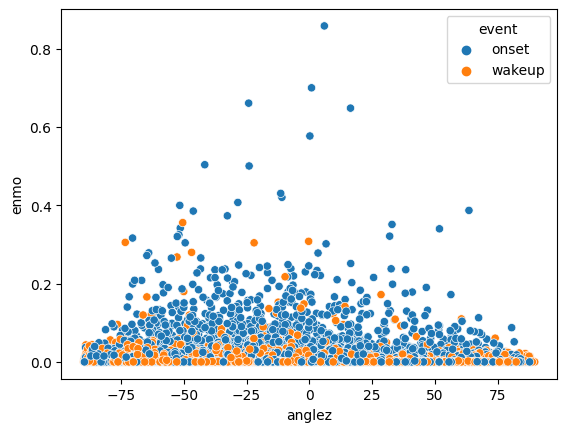

In [ ]:
sns.scatterplot(x=data_1['anglez'],y=data_1['enmo'],hue=data_1['event'])

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
anglez_scaled = scaler.fit_transform(data_1[['anglez']]).reshape(1,-1)[0]

<Axes: ylabel='enmo'>

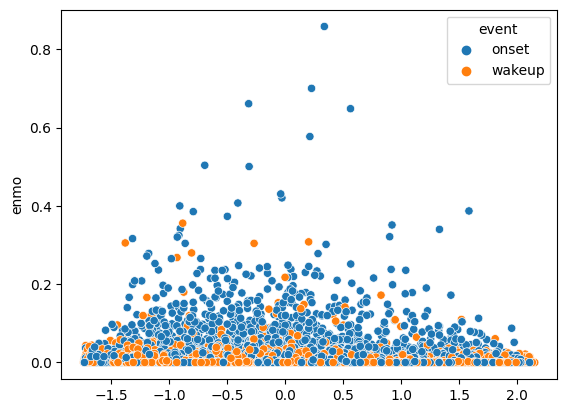

In [ ]:
sns.scatterplot(x=anglez_scaled,y=data_1['enmo'],hue=data_1['event'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
anglez_scaled = scaler.fit_transform(data_1[['anglez']]).reshape(1,-1)[0]

<Axes: ylabel='enmo'>

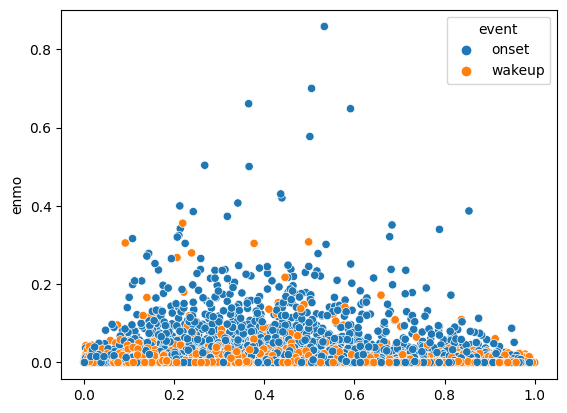

In [ ]:
sns.scatterplot(x=anglez_scaled,y=data_1['enmo'],hue=data_1['event'])

- There is no clear linear or strong correlation between anglez and enmo.
- Both onset and wakeup events are scattered across a wide range of values for both features.

- Several enmo values are greater than zero during the sleep onset phase.

- This indicates that low-level activity may still occur while a person is falling asleep or during sleep, which is consistent with natural body movements.

- Neither anglez nor enmo alone appears sufficient to clearly distinguish between sleep and wake states.

- **Improved sleep state classification may require the combination of multiple features or the inclusion of temporal patterns (e.g., sequences of measurements over time).**

## Feature Trasformation

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
enmo = pt.fit_transform(data_1[['enmo']]).reshape(1,-1)[0]

In [ ]:
pt = PowerTransformer(method='yeo-johnson')
anglez = pt.fit_transform(data_1[['anglez']]).reshape(1,-1)[0]

<Axes: >

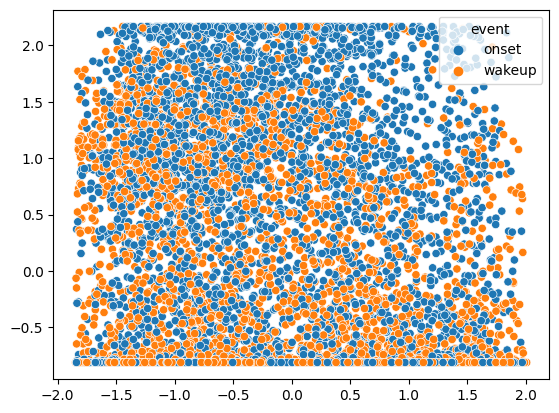

In [ ]:
sns.scatterplot(x=anglez,y=enmo,hue=data_1['event'])

Even after performing feature transformation, the data distribution remains non-linear and exhibits abnormalities. Therefore, models such as Logistic Regression, Naive Bayes, and Support Vector Machines—which rely on assumptions like linearity or normality—may not perform well. Although K-Nearest Neighbors (KNN) is non-parametric and does not assume a specific distribution, it is still sensitive to irregular or skewed data distributions. As such, KNN is also not suitable in this case.

In [ ]:

data_1 = data_1.with_columns([
    pl.Series("anglez", anglez),
    pl.Series("enmo",enmo)
])
data_1

anglez,enmo,event
f64,f64,str
-1.574483,0.30133,"""onset"""
-1.159802,1.299062,"""wakeup"""
0.144541,0.902244,"""onset"""
-0.76982,0.79776,"""wakeup"""
0.247447,-0.811231,"""onset"""
…,…,…
-1.043835,-0.273889,"""wakeup"""
-0.089867,-0.811231,"""onset"""
-0.714734,-0.811231,"""wakeup"""


In [ ]:
x=data_1[['anglez','enmo']]
y = data_1['event'].to_pandas().map({"onset": 0, "wakeup": 1})

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=27)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [ ]:
dt=DecisionTreeClassifier()
rf=RandomForestClassifier()
xgb=XGBClassifier()

**DecisionTree**

In [ ]:
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [ ]:
y_pred=dt.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.5647181628392485
0.5605900948366702


**RandomForest**

In [ ]:
rf.fit(x_train,y_train)

RandomForestClassifier()

In [ ]:
y_pred=rf.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.5829853862212944
0.5655247417074497


In [ ]:
import optuna

In [ ]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 30),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(x_train, y_train)

    preds = model.predict(x_test)
    accuracy = f1_score(y_test, preds)
    return accuracy
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best score (accuracy):", study.best_value)
print("Best parameters:", study.best_params)

[I 2025-05-04 09:42:16,891] A new study created in memory with name: no-name-b51e02cc-4815-44f7-989c-c189d4596c21
[I 2025-05-04 09:42:20,759] Trial 0 finished with value: 0.5751702462022001 and parameters: {'n_estimators': 246, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.5751702462022001.
[I 2025-05-04 09:42:26,348] Trial 1 finished with value: 0.5940390544707091 and parameters: {'n_estimators': 329, 'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 1 with value: 0.5940390544707091.
[I 2025-05-04 09:42:43,642] Trial 2 finished with value: 0.5845835488877392 and parameters: {'n_estimators': 933, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.5940390544707091.
[I 2025-05-04 09:42:48,029] Trial 3 finished with value: 0.6064648537711647 

Best score (accuracy): 0.6657801418439716
Best parameters: {'n_estimators': 793, 'max_depth': 3, 'min_samples_split': 4, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False}


In [ ]:
random_forest_best_params=study.best_params

In [ ]:
random_forest_best_params

{'n_estimators': 793,
 'max_depth': 3,
 'min_samples_split': 4,
 'min_samples_leaf': 7,
 'max_features': None,
 'bootstrap': False}

**XGBoost**

In [ ]:
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred=xgb.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.6038622129436325
0.6313744536182613


In [ ]:
import optuna


In [ ]:
def obj(trial):
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_loguniform("lambda", 1e-3, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 1e-3, 10.0),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
    }

    model = XGBClassifier(**param)
    model.fit(x_train, y_train)

    preds = model.predict(x_test)
    acc = f1_score(y_test, preds)
    return acc

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(obj, n_trials=50)

print("Best trial:")
print(study.best_trial)

print("\nBest hyperparameters:")
print(study.best_params)

[I 2025-05-04 09:50:30,416] A new study created in memory with name: no-name-1515be97-bb08-4fe4-b9d8-cf6905945f12
[I 2025-05-04 09:50:30,649] Trial 0 finished with value: 0.6390532544378699 and parameters: {'booster': 'gbtree', 'lambda': 0.21555322304034952, 'alpha': 3.6024548063286868, 'subsample': 0.6017996206947007, 'colsample_bytree': 0.731978670623153, 'max_depth': 7, 'learning_rate': 0.01552348902174618, 'n_estimators': 342}. Best is trial 0 with value: 0.6390532544378699.
[I 2025-05-04 09:50:35,007] Trial 1 finished with value: 0.6366307541625857 and parameters: {'booster': 'dart', 'lambda': 0.0016242525935635328, 'alpha': 0.026081332395231353, 'subsample': 0.6738241095758966, 'colsample_bytree': 0.6671762724049157, 'max_depth': 7, 'learning_rate': 0.024956480946562047, 'n_estimators': 249}. Best is trial 0 with value: 0.6390532544378699.
[I 2025-05-04 09:50:35,377] Trial 2 finished with value: 0.6267056530214425 and parameters: {'booster': 'gbtree', 'lambda': 0.0013264858951078

Best trial:
FrozenTrial(number=47, state=1, values=[0.6446199407699901], datetime_start=datetime.datetime(2025, 5, 4, 9, 51, 32, 278613), datetime_complete=datetime.datetime(2025, 5, 4, 9, 51, 32, 540804), params={'booster': 'gbtree', 'lambda': 0.5017075930678215, 'alpha': 0.3302015270546656, 'subsample': 0.9011631282811005, 'colsample_bytree': 0.6137937631214214, 'max_depth': 4, 'learning_rate': 0.018919187631972586, 'n_estimators': 475}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'booster': CategoricalDistribution(choices=('gbtree', 'dart')), 'lambda': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'alpha': FloatDistribution(high=10.0, log=True, low=0.001, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.5, step=None), 'max_depth': IntDistribution(high=10, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=True, low=0

In [ ]:
study.best_value

0.6446199407699901

In [ ]:
xgb_best_params=study.best_params

In [ ]:
xgb_best_params

{'booster': 'gbtree',
 'lambda': 0.5017075930678215,
 'alpha': 0.3302015270546656,
 'subsample': 0.9011631282811005,
 'colsample_bytree': 0.6137937631214214,
 'max_depth': 4,
 'learning_rate': 0.018919187631972586,
 'n_estimators': 475}

In [ ]:
xgb = XGBClassifier(**xgb_best_params)

In [ ]:
xgb.fit(x_train,y_train)

XGBClassifier(alpha=0.3302015270546656, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6137937631214214, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.5017075930678215,
              learning_rate=0.018919187631972586, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=475, n_jobs=None, ...)

In [ ]:
y_pred=xgb.predict(x_test)
f1_score(y_test,y_pred)

0.6446199407699901

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

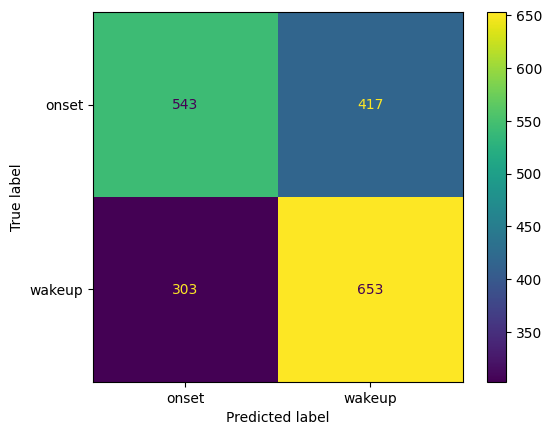

In [ ]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),display_labels=["onset","wakeup"]).plot()
plt.show()


In [ ]:
rf=RandomForestClassifier(**random_forest_best_params)

In [ ]:
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=False, max_depth=3, max_features=None,
                       min_samples_leaf=7, min_samples_split=4,
                       n_estimators=793)

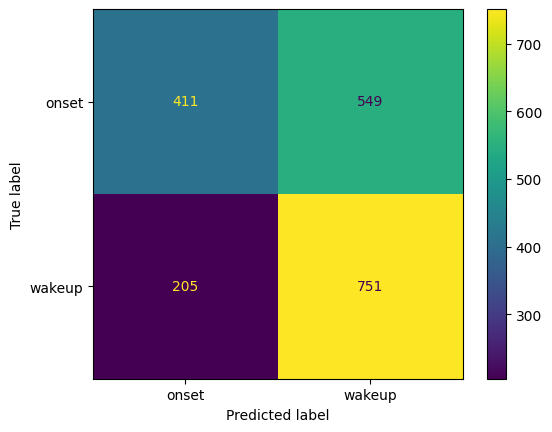

In [ ]:
y_pred=rf.predict(x_test)
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred),display_labels=["onset","wakeup"]).plot()
plt.show()

## Pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
data_2 = df.join(df1[['series_id', 'step', 'event']], on=['series_id', 'step'], how='inner').to_pandas()
data_2 = data_2.sort_values(by=['series_id', 'step'])
data_2 = data_2[['anglez', 'enmo', 'event']]

X = data_2[['anglez', 'enmo']]
y = data_2['event'].map({"onset": 0, "wakeup": 1})

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)



In [ ]:

in_features = ['anglez', 'enmo']
transformer = ColumnTransformer(
    transformers=[
        ('power', PowerTransformer(method='yeo-johnson'), in_features)
    ],
    remainder='passthrough'
)

pipe = Pipeline([
    ('preprocessing', transformer),
    ('classifier', RandomForestClassifier(**random_forest_best_params)) ]
)

pipe.fit(x_train, y_train)



Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('power', PowerTransformer(),
                                                  ['anglez', 'enmo'])])),
                ('classifier',
                 RandomForestClassifier(bootstrap=False, max_depth=3,
                                        max_features=None, min_samples_leaf=7,
                                        min_samples_split=4,
                                        n_estimators=793))])

In [ ]:
y_pred = pipe.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.6064718162839249
0.6657801418439716


In [ ]:
y_pred = pipe.predict(x_test)
print(accuracy_score(y_test,y_pred))
print(f1_score(y_test,y_pred))

0.6064718162839249
0.6657801418439716


In [ ]:
y_pred

array([0, 1, 1, ..., 0, 1, 0])

In [ ]:
import pickle
with open("pipe.pkl",'wb') as file:
    pickle.dump(pipe,file)

In [ ]:
with open('pipe.pkl','rb') as file:
    p=pickle.load(file)

In [ ]:
sample_raw_data=data[:1000]

In [ ]:
sample_raw_data.to_pandas().to_csv("sample_raw_data.csv", index=False, encoding='utf-8-sig')

In [ ]:
sample_event_data=events.clone()

In [ ]:
sample_event_data.to_pandas().to_csv("sample_event_data.csv", index=False, encoding='utf-8-sig')

In [ ]:
sample_event_data

series_id,night,event,step,timestamp
str,i64,str,u32,str
"""038441c925bb""",1,"""onset""",4992,"""2018-08-14T22:26:00-0400"""
"""038441c925bb""",1,"""wakeup""",10932,"""2018-08-15T06:41:00-0400"""
"""038441c925bb""",2,"""onset""",20244,"""2018-08-15T19:37:00-0400"""
"""038441c925bb""",2,"""wakeup""",27492,"""2018-08-16T05:41:00-0400"""
"""038441c925bb""",3,"""onset""",39996,"""2018-08-16T23:03:00-0400"""
…,…,…,…,…
"""fe90110788d2""",33,"""wakeup""",560604,"""2017-09-06T04:07:00-0400"""
"""fe90110788d2""",34,"""onset""",574620,"""2017-09-06T23:35:00-0400"""
"""fe90110788d2""",34,"""wakeup""",581604,"""2017-09-07T09:17:00-0400"""
